In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [38]:
# 1) Define the Oscillatory Network
class OscillatorNet(nn.Module):
    def __init__(self, input_dim, num_osc, T=5.0, dt=0.05):
        """
        input_dim: dimension of the input features
        num_osc:  number of phase oscillators in the network
        T:        total simulation time
        dt:       integration time step
        """
        super().__init__()
        self.N = num_osc
        self.steps = int(T / dt)
        self.dt = dt

        # a) map input -> natural frequencies ω_i
        self.fc_in = nn.Linear(input_dim, self.N)

        # b) learnable coupling matrix K_ij (not necessarily symmetric)
        self.K = nn.Parameter(torch.randn(self.N, self.N) * 0.1)

        # c) read‑out: from (cos θ, sin θ) of all oscillators -> 2 classes
        self.fc_out = nn.Linear(2 * self.N, 2)

    def forward(self, x):
        """
        x: (batch_size, input_dim)
        returns: logits of shape (batch_size, 2)
        """
        batch = x.size(0)
        # map to natural frequencies
        omega = self.fc_in(x)  # (batch, N)

        # initialize phases uniformly in [0,2π)
        theta = 2 * np.pi * torch.rand(batch, self.N, device=x.device)

        for _ in range(self.steps):
            # compute pairwise sin(θ_j - θ_i) for each example
            # sin_diff: (batch, N, N)
            th_i = theta.unsqueeze(2)   # (batch, N, 1)
            th_j = theta.unsqueeze(1)   # (batch, 1, N)
            sin_diff = torch.sin(th_j - th_i)

            # coupling term: for each i, sum_j K_ij * sin(θ_j - θ_i)
            # => coupling: (batch, N)
            coupling = torch.einsum('bij,ij->bi', sin_diff, self.K) / self.N

            # phase update (Euler integration)
            dtheta = omega + coupling
            theta = theta + self.dt * dtheta

        # read‑out features: concat[cos θ, sin θ]
        feats = torch.cat([torch.cos(theta), torch.sin(theta)], dim=1)  # (batch, 2N)
        logits = self.fc_out(feats)                                     # (batch, 2)
        return logits


# -- same data loading / splits as before --

class OscillatorNetFixed(nn.Module):
    def __init__(self, input_dim, num_osc, T=2.0, dt=0.1, omega_scale=1.0):
        super().__init__()
        self.N     = num_osc
        self.steps = int(T/dt)
        self.dt    = dt
        self.osc_in     = nn.Linear(input_dim, self.N)
        self.omega_scale = omega_scale

        # learn a free matrix A, then build K = softplus(A + A^T) / N
        self.A = nn.Parameter(torch.randn(self.N, self.N) * 0.1)

        self.fc_out = nn.Linear(2*self.N, 2)

    def forward(self, x):
        batch = x.size(0)

        # 1) Natural frequencies: tanh to bound them
        raw = self.osc_in(x)
        omega = torch.tanh(raw) * self.omega_scale            # shape (batch, N)

        # 2) Fixed initial phases
        theta = torch.zeros(batch, self.N, device=x.device)

        # 3) Build a symmetric, positive coupling matrix
        K = torch.nn.functional.softplus(self.A + self.A.t()) / self.N  # shape (N,N)
        K = torch.clamp(K, min=0.1)
        # 4) Integrate for only e.g. 20 steps
        for _ in range(self.steps):
            # compute sin differences
            th_i = theta.unsqueeze(2)   # (batch,N,1)
            th_j = theta.unsqueeze(1)   # (batch,1,N)
            sin_diff = torch.sin(th_j - th_i)  # (batch,N,N)

            # coupling term
            coup = torch.einsum('bij,ij->bi', sin_diff, K)          # (batch,N)

            # Euler update
            theta = theta + self.dt * (omega + coup)

        # readout
        feats = torch.cat([torch.cos(theta), torch.sin(theta)], dim=1)
        return self.fc_out(feats)

# Instantiate and train exactly as before, but swap in OscillatorNetFixed.
# Keep an eye on the “Using device:” printout to confirm CUDA is actually used.
# Also, after each epoch you can:
#   - inspect gradient norms: 
#       total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#   - print them to ensure they’re neither zero nor enormous.

# Finally, you should now see loss decreasing and accuracy climbing well above 50%.



class VanDerPolONN(nn.Module):
    def __init__(self, input_dim, num_osc, T=2.0, dt=0.01, mu=1.5):
        super().__init__()
        self.N = num_osc
        self.T = T
        self.steps = int(T / dt)
        self.dt = dt
        self.mu = mu

        # Project input into initial x and y states
        self.in_x = nn.Linear(input_dim, self.N)
        self.in_y = nn.Linear(input_dim, self.N)

        # Learnable symmetric coupling matrix
        self.A = nn.Parameter(torch.randn(self.N, self.N) * 0.1)

        # Output layer reads final state
        self.readout = nn.Linear(self.N * 2, 2)  # [x, y] for each oscillator

    def forward(self, x_input):
        B = x_input.size(0)
        x = self.in_x(x_input)
        y = self.in_y(x_input)

        # Make coupling symmetric and non-negative
        K = self.A #F.softplus(self.A + self.A.T) / self.N

        for _ in range(self.steps):
            dx = y
            dy = self.mu * (1 - x**2) * y - x

            # Coupling on x (can also add on y if desired)
            diff_x = x.unsqueeze(1) - x.unsqueeze(2)  # (B, N, N)
            coupling = torch.einsum('bij,ij->bi', diff_x, K)  # (B, N)
            dy = dy + coupling

            # Euler update
            x = x + self.dt * dx
            y = y + self.dt * dy

        # Optionally compute phase: theta = atan2(y, x)
        # feats = torch.cat([torch.cos(theta), torch.sin(theta)], dim=1)

        # Or use x and y directly:
        feats = torch.cat([x, y], dim=1)
        return self.readout(feats)


In [39]:
# 1) Data setup
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# 2) Device check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")   # tells you if it actually picked CUDA or CPU

# 3) DataLoaders
train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32, device=device),
    torch.tensor(y_train, dtype=torch.long,    device=device)
)
val_ds   = TensorDataset(
    torch.tensor(X_val,   dtype=torch.float32, device=device),
    torch.tensor(y_val,   dtype=torch.long,    device=device)
)
test_ds  = TensorDataset(
    torch.tensor(X_test,  dtype=torch.float32, device=device),
    torch.tensor(y_test,  dtype=torch.long,    device=device)
)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)
test_loader  = DataLoader(test_ds,  batch_size=64)

Using device: cuda


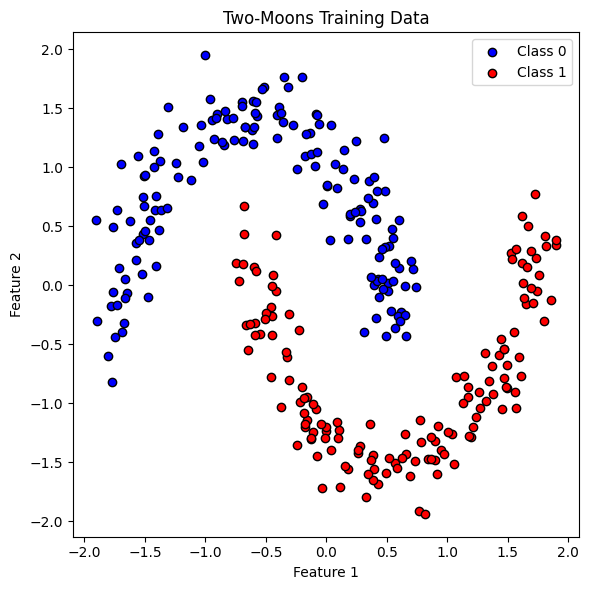

In [40]:
# 3) Plot the training data
plt.figure(figsize=(6, 6))
plt.scatter(
    X_train[y_train == 0, 0], X_train[y_train == 0, 1],
    c='blue', edgecolor='k', label='Class 0'
)
plt.scatter(
    X_train[y_train == 1, 0], X_train[y_train == 1, 1],
    c='red', edgecolor='k', label='Class 1'
)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Two‑Moons Training Data')
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# 5) Instantiate
#model     = OscillatorNet(input_dim=2, num_osc=10, T=2.0, dt=0.05).to(device)
#model     = OscillatorNetFixed(input_dim=2, num_osc=10, T=2.0, dt=0.05).to(device)

model     = VanDerPolONN(input_dim=2, num_osc=2, T=15.0, dt=0.01).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [42]:
# 6) Training with loss & accuracy tracking
epochs = 60
train_losses, val_losses = [], []
train_accs, val_accs     = [], []

for epoch in range(1, epochs+1):
    # --- train ---
    model.train()
    running_loss, running_correct = 0.0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss    += loss.item() * xb.size(0)
        running_correct += (logits.argmax(1) == yb).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc  = running_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # --- validate ---
    model.eval()
    running_loss, running_correct = 0.0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            loss   = criterion(logits, yb)
            running_loss    += loss.item() * xb.size(0)
            running_correct += (logits.argmax(1) == yb).sum().item()
    val_loss = running_loss / len(val_loader.dataset)
    val_acc  = running_correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:2d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f} | "
              f"Val Loss:   {val_loss:.4f}, Acc: {val_acc:.3f}")

Epoch 10 | Train Loss: 0.2790, Acc: 0.877 | Val Loss:   0.3117, Acc: 0.880
Epoch 20 | Train Loss: 0.2119, Acc: 0.940 | Val Loss:   0.2533, Acc: 0.930
Epoch 30 | Train Loss: 0.1737, Acc: 0.957 | Val Loss:   0.2141, Acc: 0.930
Epoch 40 | Train Loss: 0.1452, Acc: 0.963 | Val Loss:   0.1841, Acc: 0.940
Epoch 50 | Train Loss: 0.1225, Acc: 0.973 | Val Loss:   0.1593, Acc: 0.950
Epoch 60 | Train Loss: 0.1023, Acc: 0.987 | Val Loss:   0.1357, Acc: 0.970



Test Accuracy: 0.960


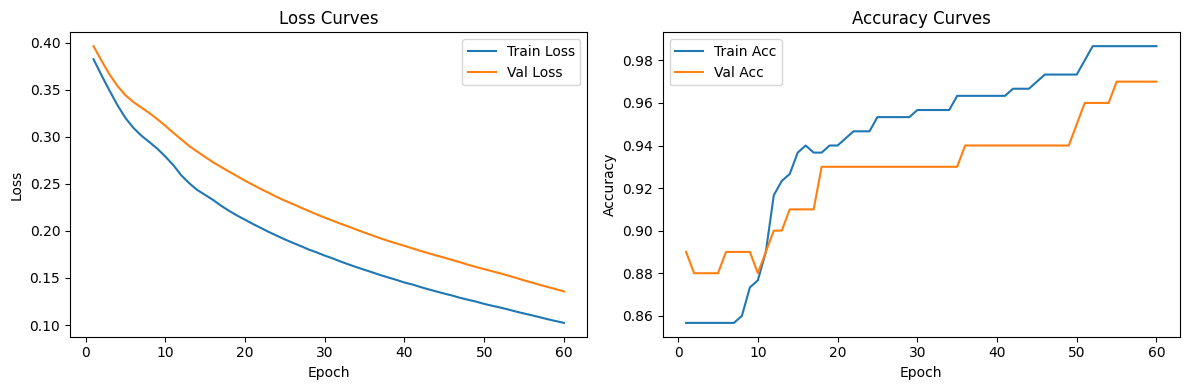

In [43]:
# 7) Final test accuracy
model.eval()
running_correct = 0
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        running_correct += (logits.argmax(1) == yb).sum().item()
test_acc = running_correct / len(test_loader.dataset)
print(f"\nTest Accuracy: {test_acc:.3f}")

# 8) Plot losses and accuracies
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, epochs+1), train_losses, label='Train Loss')
axes[0].plot(range(1, epochs+1), val_losses,   label='Val Loss')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend(); axes[0].set_title('Loss Curves')

axes[1].plot(range(1, epochs+1), train_accs, label='Train Acc')
axes[1].plot(range(1, epochs+1), val_accs,   label='Val Acc')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].legend(); axes[1].set_title('Accuracy Curves')

plt.tight_layout()
plt.show()

# Testing

Device for inference: cuda


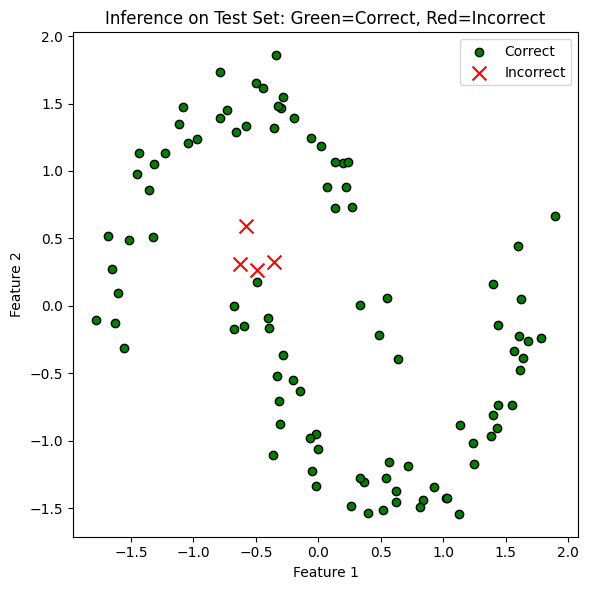

In [44]:


# 1) Make sure your model is in eval mode and on the correct device
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device for inference: {device}")

# 2) Extract the test data (assuming you have test_ds from before)
X_test = test_ds.tensors[0].cpu().numpy()  # shape (N_test, 2)
y_test = test_ds.tensors[1].cpu().numpy()  # shape (N_test,)

# 3) Run inference
with torch.no_grad():
    inputs = torch.tensor(X_test, dtype=torch.float32, device=device)
    logits = model(inputs)            # shape (N_test, 2)
    preds = logits.argmax(dim=1).cpu().numpy()

# 4) Plot the results
plt.figure(figsize=(6,6))

# Correctly classified points
correct = preds == y_test
plt.scatter(
    X_test[correct, 0], X_test[correct, 1],
    c='green', marker='o', edgecolor='k', label='Correct'
)

# Misclassified points
incorrect = preds != y_test
plt.scatter(
    X_test[incorrect, 0], X_test[incorrect, 1],
    c='red', marker='x', s=100, label='Incorrect'
)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Inference on Test Set: Green=Correct, Red=Incorrect')
plt.legend()
plt.tight_layout()
plt.show()


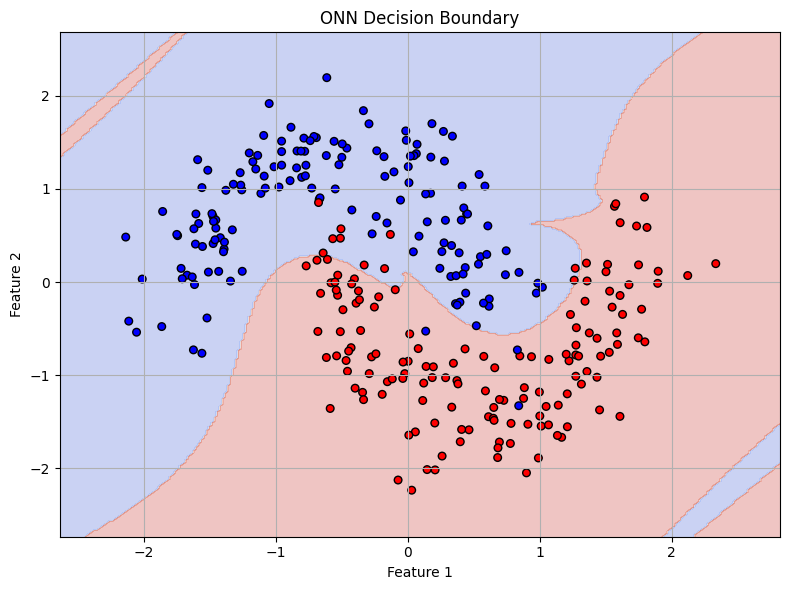

In [45]:
from sklearn.preprocessing import StandardScaler

# Create dataset
X, y = make_moons(n_samples=300, noise=0.2, random_state=0)
y_binary = y  # keep 0/1 for plotting
y = 2 * y - 1  # convert to {-1, +1}

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled = X
_, X_test, _, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


model.eval()

# Meshgrid over input space
h = 0.02
x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

# Get model predictions
with torch.no_grad():
    logits = model(grid_tensor)
    probs = torch.softmax(logits, dim=1)
    pred_class = probs.argmax(dim=1).cpu().numpy()

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_class.reshape(xx.shape), alpha=0.3, cmap='coolwarm')
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_binary, cmap='bwr', edgecolors='k', s=30)
plt.title("ONN Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
model.T/(2*np.pi)

2.3873241463784303

# Coupling matrix

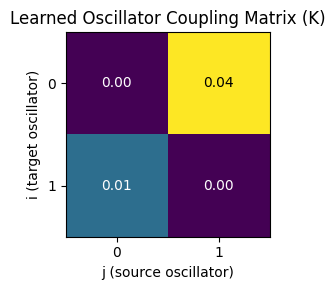

In [46]:
# assume `model` is your trained OscillatorNet on `device`
#K = model.K.detach().cpu().numpy()   # if you used the plain K parameter
# If you’re using the “fixed” variant with A→softplus(A+A.T):
from torch.nn.functional import softplus



from matplotlib.ticker import MaxNLocator # Import the locator

K = model.A.detach().cpu().numpy()
#K = softplus(model.A+ model.A.t()).detach().cpu().numpy() / model.N
np.fill_diagonal(K, 0)
# --------------------------------------

# Use the object-oriented approach (fig, ax) which is more flexible
fig, ax = plt.subplots(figsize=(3, 3))

ax.imshow(K, cmap='viridis', aspect='equal')
ax.set_title('Learned Oscillator Coupling Matrix (K)')
ax.set_xlabel('j (source oscillator)')
ax.set_ylabel('i (target oscillator)')

# --- NEW: Set integer ticks using a Locator ---
# This automatically finds the best integer ticks to display
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# --------------------------------------------

# Add text annotations (note we use ax.text now)
threshold = K.max() / 2.
num_oscillators = K.shape[0]
for i in range(num_oscillators):
    for j in range(num_oscillators):
        text_color = "white" if K[i, j] < threshold else "black"
        ax.text(j, i, f"{K[i, j]:.2f}",
                ha="center", va="center", color=text_color)

fig.tight_layout()
plt.show()


In [48]:
model.A

Parameter containing:
tensor([[ 0.1190,  0.0389],
        [ 0.0141, -0.1568]], device='cuda:0', requires_grad=True)

In [19]:
@torch.no_grad()
def simulate_vdp_onn_dynamics(model, x_input, T=2.0, dt=0.01, return_all=True, device='cpu'):
    model.eval()
    x_input = x_input.to(device)

    B = x_input.size(0)
    N = model.N
    steps = int(T / dt)

    # Get initial conditions
    x = model.in_x(x_input)
    y = model.in_y(x_input)

    x_hist = []
    y_hist = []

    # Precompute symmetric coupling
    A_sym = model.A + model.A.T
    K = F.softplus(A_sym) / N  # shape (N, N)
    K = model.A

    for _ in range(steps):
        dx = y
        dy = model.mu * (1 - x**2) * y - x

        # Coupling on x
        diff_x = x.unsqueeze(1) - x.unsqueeze(2)  # (B, N, N)
        coupling = torch.einsum('bij,ij->bi', diff_x, K)
        dy = dy + coupling

        # Euler integration
        x = x + dt * dx
        y = y + dt * dy

        if return_all:
            x_hist.append(x.clone().cpu())
            y_hist.append(y.clone().cpu())

    if return_all:
        x_hist = torch.stack(x_hist, dim=0)  # (T, B, N)
        y_hist = torch.stack(y_hist, dim=0)  # (T, B, N)
        return x_hist, y_hist, K.cpu()
    else:
        return x, y, K.cpu()

def compute_phase(x_hist, y_hist):
    return torch.atan2(y_hist, x_hist)

def compute_amplitude(x_hist, y_hist):
    return torch.sqrt(x_hist**2 + y_hist**2)

def compute_kuramoto_order(theta_hist):
    T, B, N = theta_hist.shape
    R_vals = []

    for t in range(T):
        phases = theta_hist[t]  # (B, N)
        exp_i_theta = torch.exp(1j * phases)
        R_t = torch.abs(exp_i_theta.mean(dim=1))  # (B,)
        R_vals.append(R_t.cpu().numpy())
    return np.stack(R_vals, axis=0)  # (T, B)

def compute_energy(theta_hist, K):
    T, B, N = theta_hist.shape
    E_vals = []

    for t in range(T):
        theta = theta_hist[t]  # (B, N)
        th_i = theta.unsqueeze(2)
        th_j = theta.unsqueeze(1)
        cos_diff = torch.cos(th_i - th_j)  # (B, N, N)
        energy = -0.5 * (cos_diff * K).sum(dim=[1, 2])  # (B,)
        E_vals.append(energy.cpu().numpy())
    return np.stack(E_vals, axis=0)  # (T, B)

def plot_phase_amplitude_energy_R(x_hist, y_hist, K):
    theta_hist = compute_phase(x_hist, y_hist)
    amp_hist = compute_amplitude(x_hist, y_hist)
    R_t = compute_kuramoto_order(theta_hist)
    E_t = compute_energy(theta_hist, K)
    N_osc = x_hist.shape[2]

    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
    color_list = ['b', 'r']
    for i in range(N_osc):
        axs[0].plot(np.unwrap(theta_hist[:, 0, i].numpy()), label=f'osc {i}') 
    axs[0].set_ylabel("Phase θ_i(t)")
    axs[0].set_title("Oscillator Phases Over Time")
    axs[0].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

    for i in range(N_osc):
        axs[1].plot(amp_hist[:, 0, i].numpy(), color = color_list[i], label=f'osc {i}') 
        #axs[1].plot(amp_hist[:, 0].numpy())  # Amplitudes
    axs[1].set_ylabel("Amplitude A_i(t)")
    axs[1].set_title("Amplitude Dynamics")
    axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

    axs[2].plot(R_t[:, 0])
    axs[2].set_ylabel("R(t)")
    axs[2].set_title("Kuramoto Order Parameter")

    axs[3].plot(E_t[:, 0])
    axs[3].set_ylabel("Energy E(t)")
    axs[3].set_xlabel("Time Steps")
    axs[3].set_title("Energy Evolution")

    # panel 4: complex plane trajectory
    fig, ax = plt.subplots(figsize=(4, 4))
    rmax = amp_hist[:, 0, :].max() * 1.1
    for i in range(N_osc):
        z = amp_hist[:, 0, i].numpy() * np.exp(1j * theta_hist[:, 0, i].numpy())
        ax.plot(z.real, z.imag, '-', lw=1.5, color = color_list[i], label=f'osc {i}')
        plt.plot(z.real[-1], z.imag[-1], 'o',markersize=10, color=color_list[i])
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-rmax, rmax)
    ax.set_ylim(-rmax, rmax)
    ax.set_title(f'Osc State Space Trajectory')
    ax.set_xlabel('state x')
    ax.set_ylabel('state dx/dt')
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
    ax.grid(True)
    

    plt.tight_layout()
    plt.show()
    z_real_T = z.real[-1]
    z_imag_T = z.imag[-1]

def get_state_space(x_hist, y_hist, K):
    theta_hist = compute_phase(x_hist, y_hist)
    amp_hist = compute_amplitude(x_hist, y_hist)
    N_osc = x_hist.shape[2]
    z_real_T = np.zeros(amp_hist.shape)
    z_imag_T = np.zeros(amp_hist.shape)
    for i in range(N_osc):
        z = amp_hist[:, 0, i].numpy() * np.exp(1j * theta_hist[:, 0, i].numpy())
        z_real_T[i,:,:] = z.real[-1]
        z_imag_T[i,:,:] = z.imag[-1]
    return z_real_T, z_imag_T

torch.Size([1500, 197, 2]) torch.Size([1500, 197, 2])
torch.Size([1500, 203, 2]) torch.Size([1500, 203, 2])


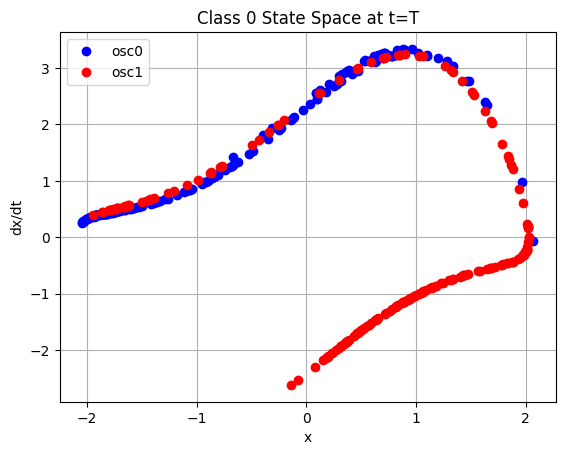

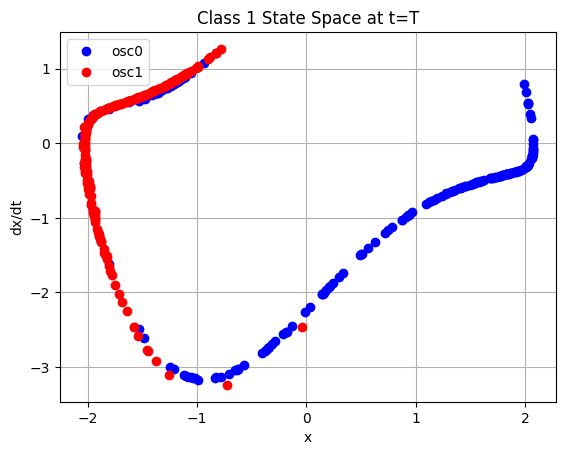

In [23]:
X, y = make_moons(n_samples=2000, noise=0.1, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data = X_test[y_test==0]
#data = np.array([[-2, 0], [-1.5, 1], [0, 1.5], [0.5, 1.0], [0.5, -0.5]])

x_hist, y_hist, K = simulate_vdp_onn_dynamics(model, torch.tensor(data).float(), T=model.T, dt=model.dt, device=device)
print(x_hist.shape, y_hist.shape)
color = ['blue','red']
labels = ['osc0', 'osc1']
plt.figure()
for i in range(model.N):
    plt.plot(x_hist[-1,:,i],y_hist[-1,:,i], 'o', color = color[i], label=labels[i])
plt.title('Class 0 State Space at t=T')
plt.legend()
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(True)

data = X_test[y_test==1]
#data = -1 * data

x_hist, y_hist, K = simulate_vdp_onn_dynamics(model, torch.tensor(data).float(), T=model.T, dt=model.dt, device=device)
print(x_hist.shape, y_hist.shape)
color = ['blue','red']
labels = ['osc0', 'osc1']
plt.figure()
for i in range(model.N):
    plt.plot(x_hist[-1,:,i],y_hist[-1,:,i], 'o', color = color[i], label=labels[i])
plt.title('Class 1 State Space at t=T')
plt.legend()
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(True)

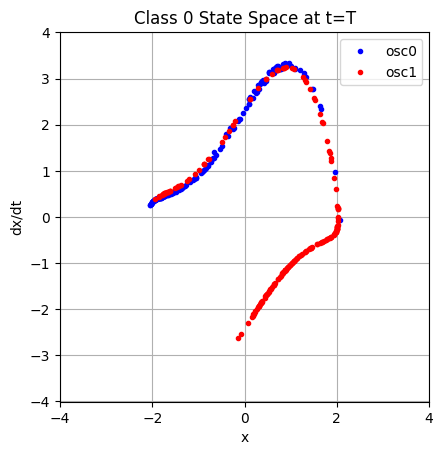

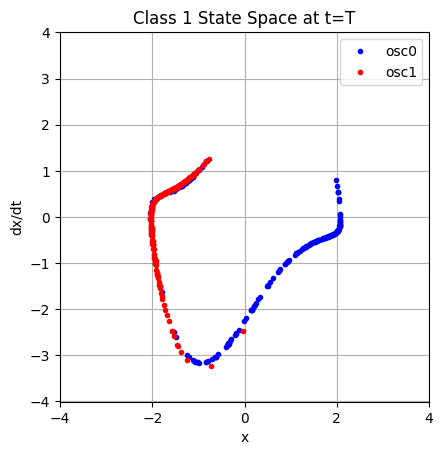

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# — simulate both classes —
data0 = X_test[y_test == 0]
x0_hist, y0_hist, _ = simulate_vdp_onn_dynamics(model,
                                                torch.tensor(data0).float(),
                                                T=model.T, dt=model.dt,
                                                device=device)

data1 = X_test[y_test == 1]
x1_hist, y1_hist, _ = simulate_vdp_onn_dynamics(model,
                                                torch.tensor(data1).float(),
                                                T=model.T, dt=model.dt,
                                                device=device)

# — extract final states (t = T) —
# shapes: (batch, N)
x0_final = x0_hist[-1, :, :]  # class 0
y0_final = y0_hist[-1, :, :]
x1_final = x1_hist[-1, :, :]  # class 1
y1_final = y1_hist[-1, :, :]

# — compute global symmetric limit —
all_vals = np.concatenate([
    x0_final.flatten(), y0_final.flatten(),
    x1_final.flatten(), y1_final.flatten()
])
L = np.max(np.abs(all_vals))*1.2  # max absolute value

color = ['blue','red']

# — plot class 0 —
plt.figure()
for i in range(model.N):
    plt.plot(x0_final[:, i], y0_final[:, i], '.', color=color[i],
             label=f'osc{i}' if i<2 else None)
plt.title('Class 0 State Space at t=T')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(True)
plt.xlim(-L, L)
plt.ylim(-L, L)
plt.gca().set_aspect('equal', 'box')
plt.legend()

# — plot class 1 —
plt.figure()
for i in range(model.N):
    plt.plot(x1_final[:, i], y1_final[:, i],'.', color=color[i],
             label=f'osc{i}' if i<2 else None)
plt.title('Class 1 State Space at t=T')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(True)
plt.xlim(-L, L)
plt.ylim(-L, L)
plt.gca().set_aspect('equal', 'box')
plt.legend()

plt.show()


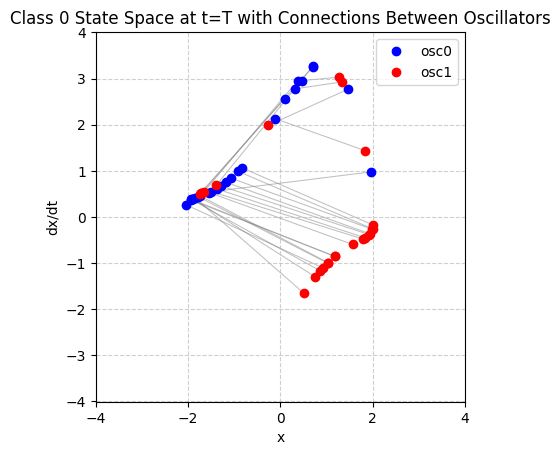

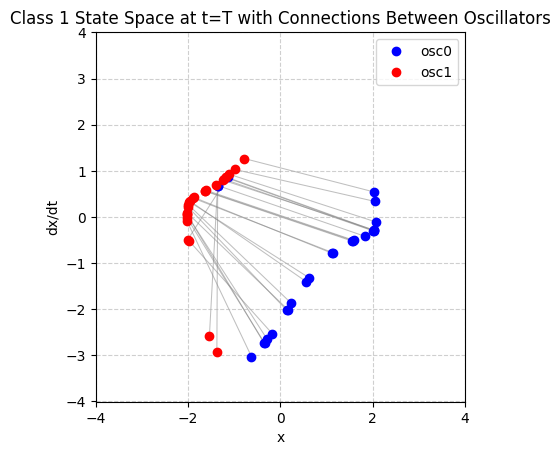

In [36]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming your other variables (model, x_hist, y_hist, etc.) are already defined
# from your simulation.

data = X_test[y_test==0]
data = data[::8]
#data = np.array([[-2, 0], [-1.5, 1], [0, 1.5], [0.5, 1.0], [0.5, -0.5]])

x_hist, y_hist, K = simulate_vdp_onn_dynamics(model, torch.tensor(data).float(), T=model.T, dt=model.dt, device=device)

colors = ['b', 'r']
labels = ['osc0', 'osc1']
plt.figure()

for i in range(model.N):
    x_final = x_hist[-1, :, i]
    y_final = y_hist[-1, :, i]

    plt.plot(x_final, y_final, 'o',color=colors[i], label=labels[i])

# Get the final states for both oscillators
x_osc0_final = x_hist[-1, :, 0]
y_osc0_final = y_hist[-1, :, 0]
x_osc1_final = x_hist[-1, :, 1]
y_osc1_final = y_hist[-1, :, 1]

# Loop through each simulation run in the batch
num_batches = x_hist.shape[1] # This is 200
for j in range(num_batches):
    # Get the coordinates for the j-th pair
    x_coords = [x_osc0_final[j], x_osc1_final[j]]
    y_coords = [y_osc0_final[j], y_osc1_final[j]]

    # Plot a thin, semi-transparent gray line to connect them
    plt.plot(x_coords, y_coords, color='gray', linestyle='-', linewidth=0.75, alpha=0.5, zorder=1)

# --- Final plot setup ---
plt.title('Class 0 State Space at t=T with Connections Between Oscillators')
plt.xlabel("x")
plt.ylabel("dx/dt")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.xlim(-L, L)
plt.ylim(-L, L)
plt.gca().set_aspect('equal', 'box')
plt.show()

data = X_test[y_test==1]
data = data[::8]
#data = np.array([[-2, 0], [-1.5, 1], [0, 1.5], [0.5, 1.0], [0.5, -0.5]])

x_hist, y_hist, K = simulate_vdp_onn_dynamics(model, torch.tensor(data).float(), T=model.T, dt=model.dt, device=device)

colors = ['b', 'r']
labels = ['osc0', 'osc1']
plt.figure()

for i in range(model.N):
    x_final = x_hist[-1, :, i]
    y_final = y_hist[-1, :, i]

    plt.plot(x_final, y_final, 'o',color=colors[i], label=labels[i])

# Get the final states for both oscillators
x_osc0_final = x_hist[-1, :, 0]
y_osc0_final = y_hist[-1, :, 0]
x_osc1_final = x_hist[-1, :, 1]
y_osc1_final = y_hist[-1, :, 1]

# Loop through each simulation run in the batch
num_batches = x_hist.shape[1] # This is 200
for j in range(num_batches):
    # Get the coordinates for the j-th pair
    x_coords = [x_osc0_final[j], x_osc1_final[j]]
    y_coords = [y_osc0_final[j], y_osc1_final[j]]

    # Plot a thin, semi-transparent gray line to connect them
    plt.plot(x_coords, y_coords, color='gray', linestyle='-', linewidth=0.75, alpha=0.5, zorder=1)

# --- Final plot setup ---
plt.title('Class 1 State Space at t=T with Connections Between Oscillators')
plt.xlabel("x")
plt.ylabel("dx/dt")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.xlim(-L, L)
plt.ylim(-L, L)
plt.gca().set_aspect('equal', 'box')
plt.show()


0
data tensor([[2., 0.]])


C:\Users\seoyumyum\AppData\Local\Temp\ipykernel_20864\2553916178.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_sample = torch.tensor(data).float().unsqueeze(0)  # shape (1, 2)


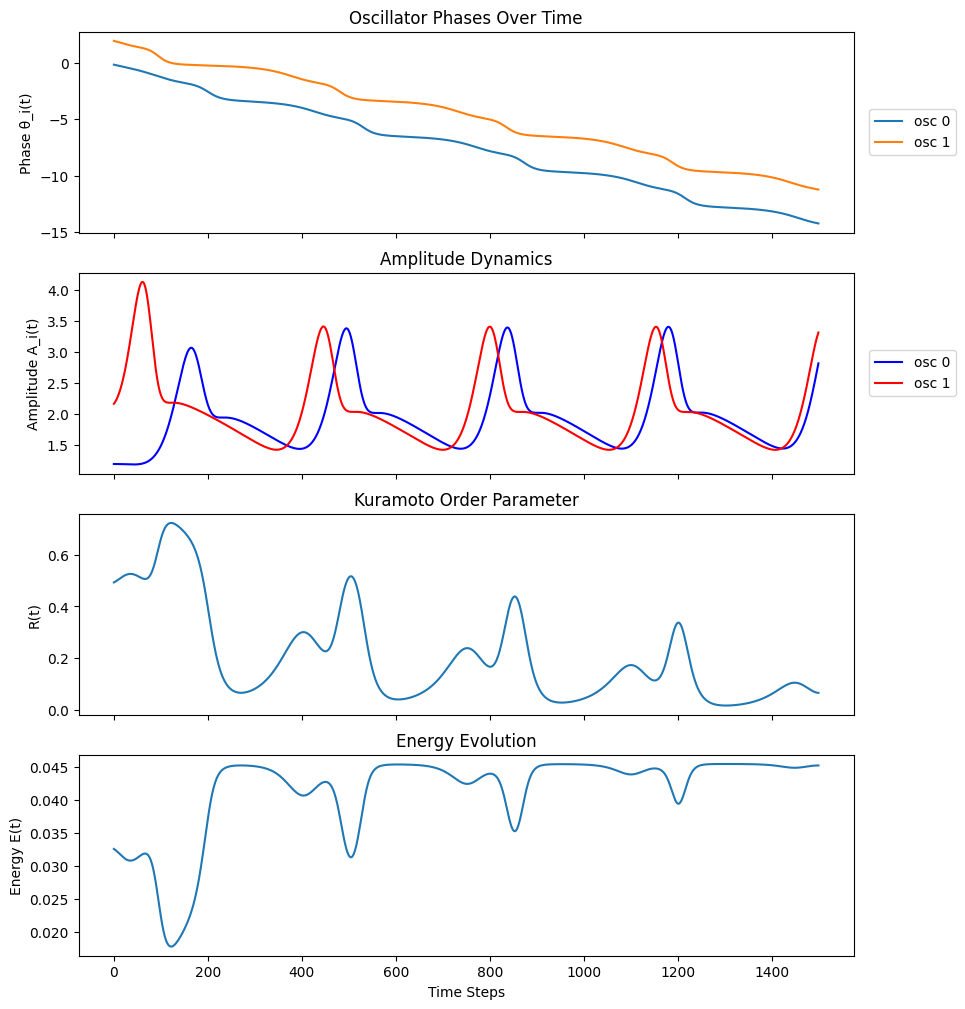

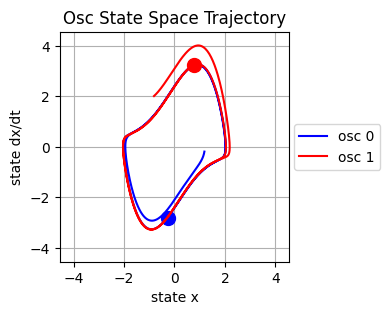

[1]


C:\Users\seoyumyum\AppData\Local\Temp\ipykernel_20864\2553916178.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x_sample, dtype=torch.float32, device=device)


In [47]:
# Assume: `model` is trained VanDerPolONN
#         `x_input` is a sample input tensor (e.g., x_test[0].unsqueeze(0))
X, y = make_moons(n_samples=2000, noise=0.1, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

test_data_flag = 1
data_idx = 11


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

if test_data_flag==1:
    data = X_test[data_idx]
    print(y_test[data_idx])
else:
    data = X_train[data_idx]
    print(y_train[data_idx])

#data = np.array([[-2, 0], [-1.5, 1], [0, 1.5], [0.5, 1.0], [0.5, -0.5]])
data = -1*torch.tensor([-2,0])

x_sample = torch.tensor(data).float().unsqueeze(0)  # shape (1, 2)
print('data', x_sample)
# Simulate and analyze:
x_hist, y_hist, K = simulate_vdp_onn_dynamics(model, x_sample, T=model.T, dt=model.dt, device=device)
plot_phase_amplitude_energy_R(x_hist, y_hist, K)

with torch.no_grad():
    inputs = torch.tensor(x_sample, dtype=torch.float32, device=device)
    logits = model(inputs)            # shape (N_test, 2)
    preds = logits.argmax(dim=1).cpu().numpy()

print(preds)


# phase dynamics

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import softplus

# assume OscillatorNetFixed is already defined, and `model` is your trained instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) make an untrained copy
model_init = OscillatorNetFixed(input_dim=2, num_osc=10, T=2.0, dt=0.05).to(device)

# 2) helper to record phase trajectories
def record_phases(net, x, total_time=2.0, step=0.1):
    net.eval()
    with torch.no_grad():
        # map input -> bounded freqs
        freq = torch.tanh(net.osc_in(x.unsqueeze(0))) * net.omega_scale  # (1, N)
        # start all phases at zero
        phase = torch.zeros(1, net.N, device=x.device)                  # (1, N)
        # build symmetric positive coupling
        matA = net.A                                                   # (N, N)
        coupling_mat = softplus(matA + matA.t()) / net.N               # (N, N)
        steps = int(total_time / step)
        traj = np.zeros((steps, net.N))
        for t in range(steps):
            traj[t] = phase.cpu().numpy()
            pi = phase.unsqueeze(2)    # (1, N, 1)
            pj = phase.unsqueeze(1)    # (1, 1, N)
            sin_diff = torch.sin(pj - pi)                         # (1, N, N)
            coup    = torch.einsum('bij,ij->bi', sin_diff, coupling_mat)  # (1, N)
            phase   = phase + step * (freq + coup)
    return traj

# 3) pick one test sample
X_test_np = test_ds.tensors[0].cpu().numpy()
y_test_np = test_ds.tensors[1].cpu().numpy()
x0 = torch.tensor(X_test_np[0], dtype=torch.float32, device=device)

# 4) record trajectories
traj_before = record_phases(model_init, x0)
traj_after  = record_phases(model,      x0)
times = np.linspace(0, 2.0, traj_before.shape[0])

# 5) plot phase trajectories for first 5 oscillators
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for i in range(10):
    plt.plot(times, traj_before[:, i], label=f'osc{i}')
plt.title('Before Training')
plt.xlabel('time')
plt.ylabel('phase')
plt.ylim(-np.pi/2, np.pi/2)
plt.legend(loc='upper right', fontsize='small')

plt.subplot(1, 2, 2)
for i in range(10):
    plt.plot(times, traj_after[:, i], label=f'osc{i}')
plt.title('After Training')
plt.xlabel('time')
plt.ylim(-np.pi, np.pi)
plt.tight_layout()
plt.show()

# 6) plot coupling matrices (with detach)
K_before = softplus(model_init.A + model_init.A.t()).detach().cpu().numpy() / model_init.N
K_after  = softplus(model.A       + model.A.t()).detach().cpu().numpy() / model.N

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(K_before, cmap='viridis', aspect='equal')
plt.title('Coupling Before Training')
plt.colorbar(label='K_ij')

plt.subplot(1,2,2)
plt.imshow(K_after, cmap='viridis', aspect='equal')
plt.title('Coupling After Training')
plt.colorbar(label='K_ij')

plt.tight_layout()
plt.show()


AttributeError: 'VanDerPolONN' object has no attribute 'osc_in'

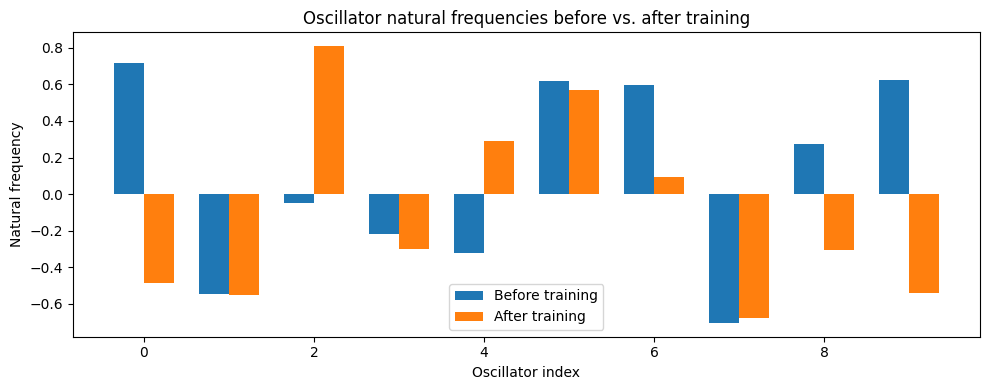

In [81]:


# 1) Make sure you recreate the untrained network with the same size
model_init = OscillatorNetFixed(
    input_dim=2,
    num_osc=model.N,     # same number of oscillators as your trained model
    T=2.0,
    dt=0.1
).to(device)
# (we leave its weights at random init)

# 2) Pick one test input (same as before)
x0 = torch.tensor(X_test[0], dtype=torch.float32, device=device)

# 3) Compute frequencies
with torch.no_grad():
    f_before = torch.tanh(model_init.osc_in(x0.unsqueeze(0))) * model_init.omega_scale  # (1,N)
    f_after  = torch.tanh(model.osc_in(x0.unsqueeze(0)))       * model.omega_scale  # (1,N)

# detach and to numpy
freq_before = f_before.detach().cpu().numpy().ravel()
freq_after  = f_after.detach().cpu().numpy().ravel()

# 4) Plot bar chart
N = freq_before.shape[0]
indices = np.arange(N)
width = 0.35

plt.figure(figsize=(10,4))
plt.bar(indices - width/2, freq_before, width, label='Before training')
plt.bar(indices + width/2, freq_after,  width, label='After training')
plt.xlabel('Oscillator index')
plt.ylabel('Natural frequency')
plt.title('Oscillator natural frequencies before vs. after training')
plt.legend()
plt.tight_layout()
plt.show()


In [82]:
import numpy as np
from torch.nn.functional import softplus

# extract the symmetric positive coupling
K_learned = softplus(model.A + model.A.t()).detach().cpu().numpy() / model.N
print("Mean abs coupling:", np.abs(K_learned).mean())


Mean abs coupling: 0.0694304


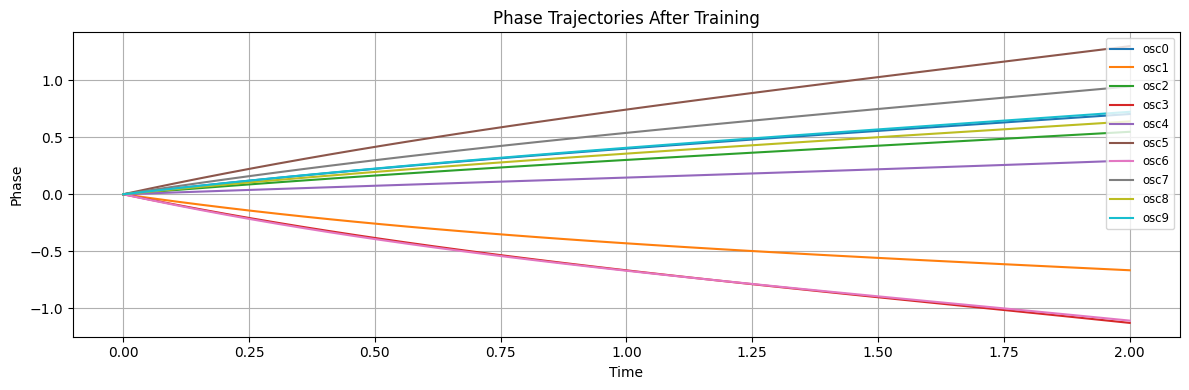

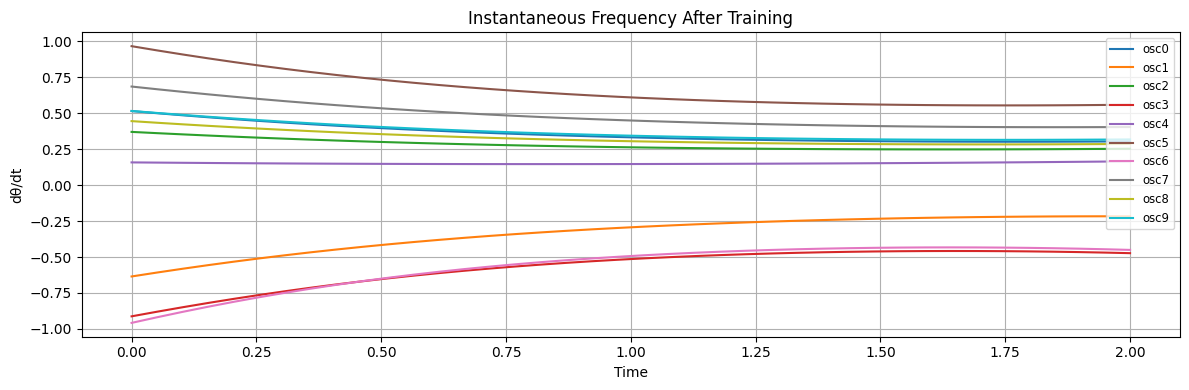

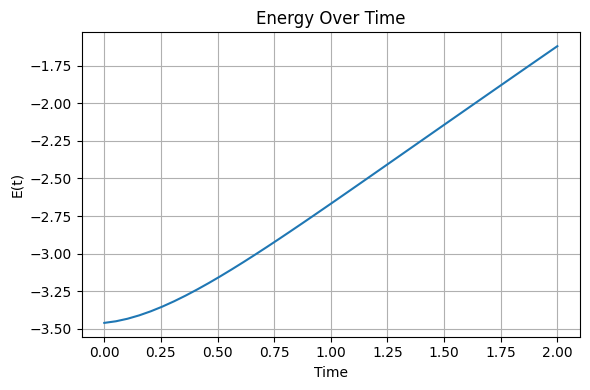

In [94]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import softplus

# Define enhanced phase recording with instantaneous frequency and energy tracking
def record_phase_dynamics(net, x, total_time=2.0, step=0.05):
    net.eval()
    with torch.no_grad():
        N = net.N
        freq = torch.tanh(net.osc_in(x.unsqueeze(0))) * net.omega_scale  # (1, N)
        phase = torch.zeros(1, N, device=x.device)                        # (1, N)
        matA = net.A                                                     # (N, N)
        K = softplus(matA + matA.t()) / N                                # (N, N)

        steps = int(total_time / step)
        traj = np.zeros((steps, N))
        inst_freq = np.zeros((steps, N))
        energy = np.zeros(steps)

        for t in range(steps):
            traj[t] = phase.cpu().numpy()
            pi = phase.unsqueeze(2)  # (1, N, 1)
            pj = phase.unsqueeze(1)  # (1, 1, N)
            sin_diff = torch.sin(pj - pi)             # (1, N, N)
            coup = torch.einsum('bij,ij->bi', sin_diff, K)  # (1, N)
            dtheta = freq + coup
            inst_freq[t] = dtheta.cpu().numpy()
            phase = phase + step * dtheta

            # Energy: E = -0.5 * sum_{ij} K_ij * cos(theta_j - theta_i)
            theta_i = phase.unsqueeze(2)
            theta_j = phase.unsqueeze(1)
            cos_diff = torch.cos(theta_j - theta_i)
            E = -0.5 * torch.sum(K * cos_diff.squeeze(0)).item()
            energy[t] = E

    return traj, inst_freq, energy

# Reuse previously defined model and inputs
x0 = torch.tensor(test_ds.tensors[0][0].cpu().numpy(), dtype=torch.float32, device=device)

# Run enhanced trajectory recording
traj, inst_freq, energy = record_phase_dynamics(model, x0)

# Time axis
times = np.linspace(0, 2.0, traj.shape[0])

# Plot phase trajectories
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.plot(times, traj[:, i], label=f'osc{i}')
plt.title("Phase Trajectories After Training")
plt.xlabel("Time")
plt.ylabel("Phase")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot instantaneous frequency
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.plot(times, inst_freq[:, i], label=f'osc{i}')
plt.title("Instantaneous Frequency After Training")
plt.xlabel("Time")
plt.ylabel("dθ/dt")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot energy over time
plt.figure(figsize=(6, 4))
plt.plot(times, energy)
plt.title("Energy Over Time")
plt.xlabel("Time")
plt.ylabel("E(t)")
plt.grid(True)
plt.tight_layout()
plt.show()
